## Asignar estacion a departamento

Asignamos a cada departamento una estacion basandonos en la cercania

In [1]:
import pandas as pd
from geopy.distance import geodesic

# Cargar datos 
df_estaciones = pd.read_csv("C:/Users/juanm/Downloads/Estaciones.csv", sep=";", encoding="latin1")
df_departamentos = pd.read_csv("C:/Users/juanm/Downloads/lista-departamentos.csv")

# Filtrar estaciones que no queremos
estaciones_a_eliminar = [
    "NH0145", "A872993", "A872994", "A872996", "A872997", 
    "A872998", "A875001", "A875000", "A872999"
]
df_estaciones = df_estaciones[~df_estaciones["Id Interno"].isin(estaciones_a_eliminar)]

# Renombrar columnas clave
df_estaciones = df_estaciones.rename(columns={
    "Id": "estacion_id",
    "Id Interno": "estacion_id_interno",
    "Nombre": "estacion_nombre",
    "Latitud": "lat_est",
    "Longitud": "lon_est"
})

df_departamentos = df_departamentos.rename(columns={
    "Código UTA 2020": "departamento_id",
    "Nombre": "departamento_nombre",
    "Latitud": "lat_dep",
    "Longitud": "lon_dep"
})

# Función para encontrar estación más cercana
def estacion_mas_cercana(lat_dep, lon_dep, estaciones):
    distancias = estaciones.apply(
        lambda row: geodesic((lat_dep, lon_dep), (row["lat_est"], row["lon_est"])).kilometers,
        axis=1
    )
    idx_min = distancias.idxmin()
    est = estaciones.loc[idx_min]
    return est["estacion_id"], est["estacion_id_interno"], est["estacion_nombre"], est["lat_est"], est["lon_est"]

# Asignar estación a cada departamento
asignaciones = []
for _, dep in df_departamentos.iterrows():
    est_id, est_id_interno, est_nombre, lat_est, lon_est = estacion_mas_cercana(dep["lat_dep"], dep["lon_dep"], df_estaciones)
    dist = geodesic((dep["lat_dep"], dep["lon_dep"]), (lat_est, lon_est)).kilometers
    asignaciones.append([
        dep["departamento_id"], dep["departamento_nombre"], dep["lat_dep"], dep["lon_dep"],
        est_id, est_id_interno, est_nombre, lat_est, lon_est, dist
    ])

df_asignado = pd.DataFrame(asignaciones, columns=[
    "departamento_id", "departamento_nombre", "lat_dep", "lon_dep",
    "estacion_id", "estacion_id_interno", "estacion_nombre", "lat_est", "lon_est",
    "distancia_km"
])

# Verificar estaciones huérfanas 
estaciones_asignadas = set(df_asignado["estacion_id_interno"])
estaciones_totales = set(df_estaciones["estacion_id_interno"])
estaciones_huerfanas = estaciones_totales - estaciones_asignadas

print("Estaciones sin departamento asignado:")
print(df_estaciones[df_estaciones["estacion_id_interno"].isin(estaciones_huerfanas)][
    ["estacion_id", "estacion_id_interno", "estacion_nombre"]
])

Estaciones sin departamento asignado:
     estacion_id estacion_id_interno                 estacion_nombre
15           468             A872838           Aparicio - EEA Barrow
33           489             A872946   Cañada Ombu - EEA Reconquista
71             9              NH0358           INTA - Castelar (EMC)
76            51              NH0464        INTA - El Colorado (EMC)
88            65              NH0437        INTA - Reconquista (EMC)
95           515             A872962    La Cigüeña - EEA Reconquista
97           482             A872939      La Consulta - EEA Consulta
123          483             A872940        Pareditas - EEA Consulta
125          718             A872969  Perito Moreno - EEA Santa Cruz
132          432             A872933     Rama Caida - EEA Rama Caida
138          250             A872812          Sachayoj - EEA Quimilí
141          358             A872890       San Pedro - EEA San Pedro
148          421             A872916     Sombrerito - EEA Corrien

## Verificaciones

Revisamos si la cantidad de filas es correctas, por si hubo duplicados

In [2]:
# Revisar la cantidad de filas es correctas
print("Filas totales en df:", len(df_asignado))
print("Departamentos únicos por ID:", df_asignado["departamento_id"].nunique())
print("Departamentos únicos por Nombre:", df_asignado["departamento_nombre"].nunique())

Filas totales en df: 530
Departamentos únicos por ID: 530
Departamentos únicos por Nombre: 458


Revisamos errores en las asignaciones y si hubo estaciones que no fueron asignadas a un departamento

In [3]:
# Revisar si hay estaciones internas que no existen en el listado original
try:
    faltantes_est = set(df_asignado["estacion_id_interno"]) - set(df_estaciones["estacion_id_interno"])
    print(f"\nEstaciones en df_asignado que no existen en df_estaciones: {len(faltantes_est)}")
    print(list(faltantes_est)[:10])
except NameError:
    print("\nNo se pudo comparar con df_estaciones porque no está cargado en el entorno.")

# Revisar si hay estaciones que quedaron sin asignar
try:
    no_usadas = set(df_estaciones["estacion_id_interno"]) - set(df_asignado["estacion_id_interno"])
    print(f"\nEstaciones que no se usaron en la asignación: {len(no_usadas)}")
    print(list(no_usadas)[:10])
except NameError:
    print("\nNo se pudo calcular 'no_usadas' porque df_estaciones no está cargado.")


Estaciones en df_asignado que no existen en df_estaciones: 0
[]

Estaciones que no se usaron en la asignación: 15
['A872946', 'A872890', 'A872916', 'A872841', 'A872940', 'A872939', 'NH0358', 'NH0437', 'A872933', 'A872838']


Revisamos los departamentos con mayor distancia a una estacion

In [4]:
# Revisamos los departamentos con mayor distancia a su estación asignada
distancia = df_asignado.sort_values("distancia_km", ascending=False).head(30)

print("Departamentos con mayor distancia a su estación asignada (km):")
print(distancia[[
    "departamento_id", "departamento_nombre",
    "estacion_id", "estacion_id_interno", "estacion_nombre",
    "distancia_km"
]].to_string(index=False))

Departamentos con mayor distancia a su estación asignada (km):
departamento_id      departamento_nombre  estacion_id estacion_id_interno                estacion_nombre  distancia_km
          94028      antartida argentina          339             A872859 San Sebastian - EEA Santa Cruz   1326.500849
          94021  islas del atlantico sur          339             A872859 San Sebastian - EEA Santa Cruz    657.336339
          66133                rivadavia          395             A872882          Palma Sola - EEA Yuto    253.797303
          10028 antofagasta de la sierra          507             A872877         Trancas - EEA Famaillá    253.174607
          34007                  bermejo          713             A872899  J J Castelli - EEA Sáenz Peña    251.840253
          58084                  norquin          434             A872935      Malargüe - EEA Rama Caida    248.558223
          34063              ramon lista          395             A872882          Palma Sola - EEA Yuto

Como podemos ver, los departamentos que mas lejos estan de una estacion son de la Antartida, de las islas, o de sitios donde hay pocas estaciones meteorologicas.

Revisamos estadisticas basicas de las distancias

Estadísticas de distancias (km):
count     530.000000
mean       62.746443
std        78.553314
min         0.494425
25%        24.545533
50%        46.113584
75%        79.215646
max      1326.500849
Name: distancia_km, dtype: float64


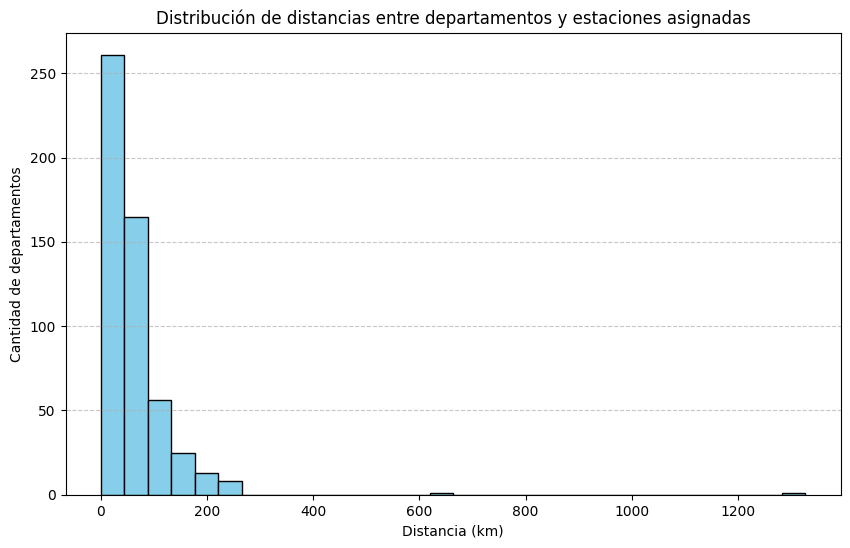

In [5]:
# Revisamos estadisticas de distribucion de distancias 
import matplotlib.pyplot as plt

# Estadísticas básicas
print("Estadísticas de distancias (km):")
print(df_asignado["distancia_km"].describe())

# Histograma de distancias
plt.figure(figsize=(10,6))
plt.hist(df_asignado["distancia_km"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de distancias entre departamentos y estaciones asignadas")
plt.xlabel("Distancia (km)")
plt.ylabel("Cantidad de departamentos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Creamos un para para visualizar bien que no haya habido errores en la asignacion 

In [6]:
import folium
import os
import webbrowser

# Crear mapa centrado en Argentina
mapa = folium.Map(location=[-38, -64], zoom_start=4)

# Agregar estaciones (puntos grandes y rojos)
for _, est in df_estaciones.iterrows():
    folium.CircleMarker(
        location=[est["lat_est"], est["lon_est"]],
        radius=6,
        color="red",
        fill=True,
        fill_color="red",
        popup=f'{est["estacion_nombre"]} ({est["estacion_id_interno"]})'
    ).add_to(mapa)

# Agregar departamentos (puntos pequeños y azules)
for _, dep in df_asignado.iterrows():
    folium.CircleMarker(
        location=[dep["lat_dep"], dep["lon_dep"]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        popup=f'{dep["departamento_nombre"]} ({dep["departamento_id"]})'
    ).add_to(mapa)
    
    # Línea desde departamento hasta su estación asignada
    folium.PolyLine(
        locations=[[dep["lat_dep"], dep["lon_dep"]], [dep["lat_est"], dep["lon_est"]]],
        color="green",
        weight=1,
        opacity=0.5
    ).add_to(mapa)

# Guardar mapa a archivo HTML
ruta_completa = os.path.abspath("mapa_departamentos_estaciones.html")
mapa.save(ruta_completa)
print(f"Mapa generado: {ruta_completa}")

# Abrir automáticamente 
webbrowser.open(f"file://{ruta_completa}")

Mapa generado: e:\Archivos F\mapa_departamentos_estaciones.html


True

## Reasignacion de estaciones "huerfanas"

Reasignamos las estaciones que sean posibles, para usar la mayor cantidad de datos, pero cuidando que no haya un aumento considerable en las distancias entre departamentos y estaciones.

In [7]:
# Diccionario de reasignaciones 
reasign_manual = {
    "A872969": "78035",
    "A872933": "50105",
    "A872940": "50091",
    "A872812": "86014",
    "A872962": "82077",
    "A872842": "6602",
    "A872970": "62007",
    "A872949": "62028",
    "A872838": "6553",
    "NH0464": "22084",
    "A872916": "18042"      
}

# Reasignar 
for est_id_interno, dep_id in reasign_manual.items():
    # Eliminar asignación automática del departamento
    df_asignado = df_asignado[df_asignado["departamento_id"] != dep_id]
    
    # Buscar la estación
    est = df_estaciones[df_estaciones["estacion_id_interno"] == est_id_interno].iloc[0]
    dep = df_departamentos[df_departamentos["departamento_id"] == dep_id].iloc[0]
    
    # Agregar nueva fila
    dist = geodesic((dep["lat_dep"], dep["lon_dep"]), (est["lat_est"], est["lon_est"])).kilometers
    nueva_fila = {
        "departamento_id": dep["departamento_id"],
        "departamento_nombre": dep["departamento_nombre"],
        "lat_dep": dep["lat_dep"],
        "lon_dep": dep["lon_dep"],
        "estacion_id": est["estacion_id"],
        "estacion_id_interno": est["estacion_id_interno"],
        "estacion_nombre": est["estacion_nombre"],
        "lat_est": est["lat_est"],
        "lon_est": est["lon_est"],
        "distancia_km": dist
    }
    df_asignado = pd.concat([df_asignado, pd.DataFrame([nueva_fila])], ignore_index=True)


Tambien reasignamos algunas estaciones que no tenian datos

## Verificacion

Revisamos que no hubo duplicados

In [8]:
# Revisar la cantidad de filas es correctas
print("Filas totales en df:", len(df_asignado))
print("Departamentos únicos por ID:", df_asignado["departamento_id"].nunique())
print("Departamentos únicos por Nombre:", df_asignado["departamento_nombre"].nunique())

Filas totales en df: 530
Departamentos únicos por ID: 530
Departamentos únicos por Nombre: 458


Vemos cuantas estaciones quedaron huerfanas

In [9]:
# Verificar estaciones huérfanas después de reasignación
estaciones_asignadas = set(df_asignado["estacion_id_interno"])
estaciones_totales = set(df_estaciones["estacion_id_interno"])
estaciones_huerfanas = estaciones_totales - estaciones_asignadas

print("Estaciones que aún no tienen departamento asignado:")
print(df_estaciones[df_estaciones["estacion_id_interno"].isin(estaciones_huerfanas)][
    ["estacion_id", "estacion_id_interno", "estacion_nombre"]
])


Estaciones que aún no tienen departamento asignado:
     estacion_id estacion_id_interno                estacion_nombre
33           489             A872946  Cañada Ombu - EEA Reconquista
71             9              NH0358          INTA - Castelar (EMC)
75            40              NH0460        INTA - Corrientes (EMC)
88            65              NH0437       INTA - Reconquista (EMC)
97           482             A872939     La Consulta - EEA Consulta
141          358             A872890      San Pedro - EEA San Pedro
168          366             A872841    Villalonga - EEA H Ascasubi


Vemos si hubo algun error en la asignacion

In [10]:
# Revisar si hay estaciones internas que no existen en el listado original
try:
    faltantes_est = set(df_asignado["estacion_id_interno"]) - set(df_estaciones["estacion_id_interno"])
    print(f"\nEstaciones en df_asignado que no existen en df_estaciones: {len(faltantes_est)}")
    print(list(faltantes_est)[:10])
except NameError:
    print("\nNo se pudo comparar con df_estaciones porque no está cargado en el entorno.")

# Revisar si hay estaciones que quedaron sin asignar
try:
    no_usadas = set(df_estaciones["estacion_id_interno"]) - set(df_asignado["estacion_id_interno"])
    print(f"\nEstaciones que no se usaron en la asignación: {len(no_usadas)}")
    print(list(no_usadas)[:10])
except NameError:
    print("\nNo se pudo calcular 'no_usadas' porque df_estaciones no está cargado.")


Estaciones en df_asignado que no existen en df_estaciones: 0
[]

Estaciones que no se usaron en la asignación: 7
['A872946', 'A872890', 'A872841', 'NH0460', 'A872939', 'NH0358', 'NH0437']


Vemos si la estaciones que asignamos esten correctamente asignadas

In [11]:
# "A872969": "78035",
# "A872933": "50105",
# "A872940": "50091",
# "A872812": "86014",
# "A872962": "82077",
# "A872842": "6602",
# "A872970": "62007",
# "A872949": "62028",
# "A872838": "6553",
# "NH0464": "22084",
# "A872916": "18042"   


print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872969"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872933"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872940"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872812"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872962"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872842"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872970"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872949"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872838"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "NH0464"].to_string(index=False))
print(df_asignado.loc[df_asignado["estacion_id_interno"] == "A872916"].to_string(index=False))

departamento_id departamento_nombre    lat_dep    lon_dep  estacion_id estacion_id_interno                estacion_nombre  lat_est  lon_est  distancia_km
          78035   lago buenos aires -46.042084 -71.658737          718             A872969 Perito Moreno - EEA Santa Cruz    -46.6   -70.92     84.159133
departamento_id departamento_nombre    lat_dep    lon_dep  estacion_id estacion_id_interno             estacion_nombre  lat_est  lon_est  distancia_km
          50105          san rafael -34.220188 -67.911636          432             A872933 Rama Caida - EEA Rama Caida   -34.67   -68.39     66.501102
departamento_id departamento_nombre    lat_dep    lon_dep  estacion_id estacion_id_interno          estacion_nombre  lat_est  lon_est  distancia_km
          50091          san carlos -33.670944 -68.980523          483             A872940 Pareditas - EEA Consulta   -33.95   -69.08     32.293963
departamento_id departamento_nombre    lat_dep    lon_dep  estacion_id estacion_id_interno    

Revisamos que no hayan quedado nulos

In [12]:
print("Cantidad nulos:", df_asignado.isnull().sum())

Cantidad nulos: departamento_id        0
departamento_nombre    0
lat_dep                0
lon_dep                0
estacion_id            0
estacion_id_interno    0
estacion_nombre        0
lat_est                0
lon_est                0
distancia_km           0
dtype: int64


## Distribuciones

Proporcion de departamentos por rango de distancia

In [14]:
bins = [0, 50, 100, 200, 500, 1000, 2000]
labels = ["<50 km", "50–100 km", "100–200 km", "200–500 km", "500–1000 km", "1000–2000 km"]

df_asignado["distancia_rango"] = pd.cut(df_asignado["distancia_km"], bins=bins, labels=labels, include_lowest=True)

proporcion_rangos = df_asignado["distancia_rango"].value_counts(normalize=True).sort_index() * 100

print("Proporción de departamentos por rango de distancia (%):")
print(proporcion_rangos)

Proporción de departamentos por rango de distancia (%):
distancia_rango
<50 km          53.396226
50–100 km       30.943396
100–200 km      11.886792
200–500 km       3.396226
500–1000 km      0.188679
1000–2000 km     0.188679
Name: proportion, dtype: float64


Estaciones con mas departamentos asignados

In [15]:
departamento_estacion = (
    df_asignado.groupby(["estacion_id_interno", "estacion_nombre"])["departamento_nombre"]
    .nunique()
    .reset_index()
    .sort_values("departamento_nombre", ascending=False)
)

departamento_estacion

,estacion_id_interno,estacion_nombre,departamento_nombre
7,A872810,Llavallol - ICyA CIRN,19
130,A872995,A872995 - CITEDEF-INTA,19
0,A872801,Castelar - ICyA CIRN,15
58,A872877,Trancas - EEA Famaillá,15
92,A872925,Hornillos - IPAF NOA,13
...,...,...,...
140,NH0421,INTA - Hilario Ascasubi (EMC),1
137,NH0400,INTA - Balcarce (EMC),1
146,NH0464,INTA - El Colorado (EMC),1
149,NH0496,INTA - Concordia (EMC),1


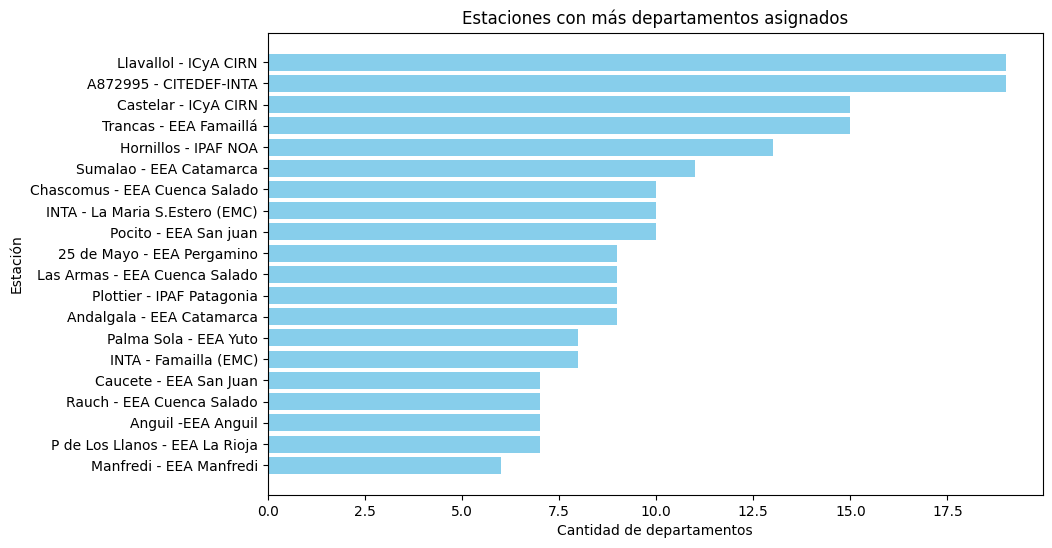

In [16]:
import matplotlib.pyplot as plt

departamento_estacion = (
    df_asignado.groupby(["estacion_id_interno", "estacion_nombre"])["departamento_nombre"]
    .nunique()
    .reset_index()
    .sort_values("departamento_nombre", ascending=False)
)

estaciones_repetidas = departamento_estacion.head(20)

plt.figure(figsize=(10,6))
plt.barh(estaciones_repetidas["estacion_nombre"], estaciones_repetidas["departamento_nombre"], color="skyblue")
plt.xlabel("Cantidad de departamentos")
plt.ylabel("Estación")
plt.title("Estaciones con más departamentos asignados")
plt.gca().invert_yaxis() 
plt.show()

## Guardamos 

In [13]:
# Exportar resultado a CSV 
df_asignado.to_csv("departamentos_con_estacion.csv", index=False, encoding="utf-8")
print("Archivo 'departamentos_con_estacion.csv' generado con éxito.")

df_asignado

Archivo 'departamentos_con_estacion.csv' generado con éxito.


,departamento_id,departamento_nombre,lat_dep,lon_dep,estacion_id,estacion_id_interno,estacion_nombre,lat_est,lon_est,distancia_km
0,82105,san jeronimo,-32.239935,-61.231266,297,A872868,Las Rosas - EEA Oliveros,-32.49,-61.57,42.253384
1,38112,yavi,-22.329812,-65.825982,516,A872923,Abra Pampa - EEA Abra Pampa,-22.80,-65.83,52.069337
2,62035,el cuy,-39.866718,-68.703438,519,A872947,Plottier - IPAF Patagonia,-38.95,-68.33,106.737771
3,6623,pergamino,-33.589305,-60.772765,236,A872814,Alfonso - EEA Pergamino,-33.91,-60.84,36.112224
4,6868,villa gesell,-37.336673,-57.032501,368,A872833,Las Armas - EEA Cuenca Salado,-37.09,-57.87,79.218609
...,...,...,...,...,...,...,...,...,...,...
525,62007,adolfo alsina,-40.633583,-63.509506,724,A872970,Valle Inferior - EEA Valle Inf.,-40.80,-63.06,42.238023
526,62028,conesa,-40.220566,-64.070602,711,A872949,Guardia Mitre - EEA V Inferior,-40.43,-63.68,40.531653
527,6553,monte hermoso,-38.995358,-61.215202,468,A872838,Aparicio - EEA Barrow,-38.67,-60.93,43.792859
528,22084,libertador general san martin,-26.514810,-59.225561,51,NH0464,INTA - El Colorado (EMC),-26.30,-59.38,28.352151
